In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# IMPORTING THE NECESSARY LIBRARIES

import pandas as pd
import numpy as np
import itertools
import os
import sys
from prettytable import PrettyTable
import pickle
from random import shuffle
from sklearn.model_selection import train_test_split
import multiprocessing
from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow.keras as keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,BatchNormalization,GlobalMaxPooling2D,concatenate,Flatten
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,Callback
from keras.initializers import random_normal
from keras.models import load_model
from keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from keras import backend as K

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False


from PIL import Image
import cv2
import tensorflow as tf


print(multiprocessing.cpu_count()," CPU cores")

2  CPU cores


In [3]:
# CHANGING TO DIRECTORY

import os

os.chdir('../input/aptos2019-blindness-detection')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /kaggle/input/aptos2019-blindness-detection


In [4]:
# LOADING DATASETS

def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [5]:
# DISPLAYING THE SIZE OF THE TRAIN AND TEST SETS BEFORE PREPROCESSING

df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')

(3662, 4) (1928, 3) 



In [6]:
# DISPLAYING THE TRAIN DATASET

df_train.head(5)

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train_images/005b95c28852.png,005b95c28852.png


In [7]:
# DISPLAYING THE TEST DATASET

df_test.head(5)

,id_code,file_path,file_name
0,0005cfc8afb6,./test_images/0005cfc8afb6.png,0005cfc8afb6.png
1,003f0afdcd15,./test_images/003f0afdcd15.png,003f0afdcd15.png
2,006efc72b638,./test_images/006efc72b638.png,006efc72b638.png
3,00836aaacf06,./test_images/00836aaacf06.png,00836aaacf06.png
4,009245722fa4,./test_images/009245722fa4.png,009245722fa4.png


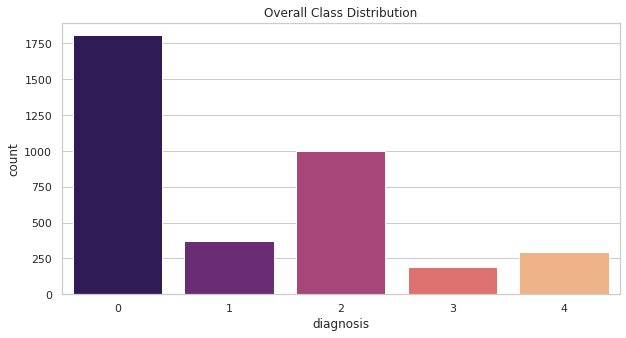

In [8]:
# PLOTTING THE DISTRIBUTION OF CLASSES

def distribute_classes(df):
    df_grouping = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_grouping.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_grouping,palette = "magma")
    plt.title('Overall Class Distribution')
    plt.show()
distribute_classes(df_train)

In [9]:
# DECLARING THE IMAGE SIZE FOR PREPROCESSING 

IMG_SIZE = 256

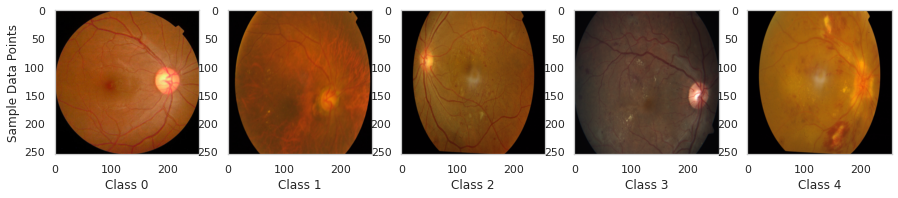

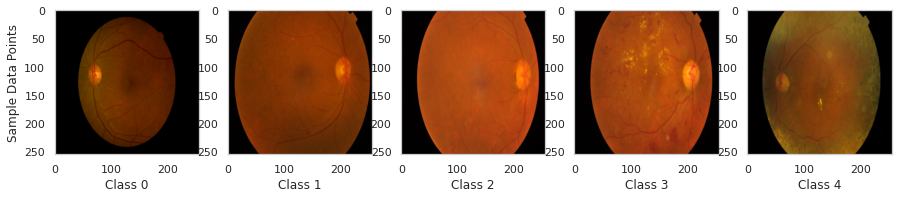

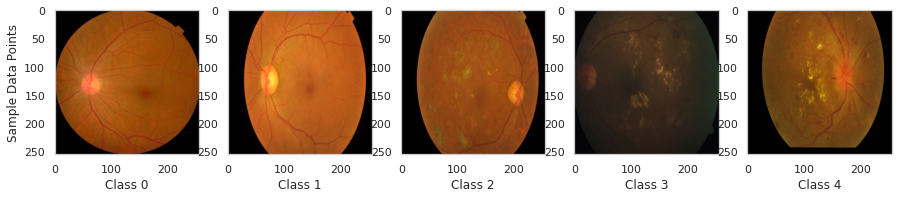

In [10]:
def convert_to_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
  
def display_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

display_imgs(df_train,3,color_scale = None)

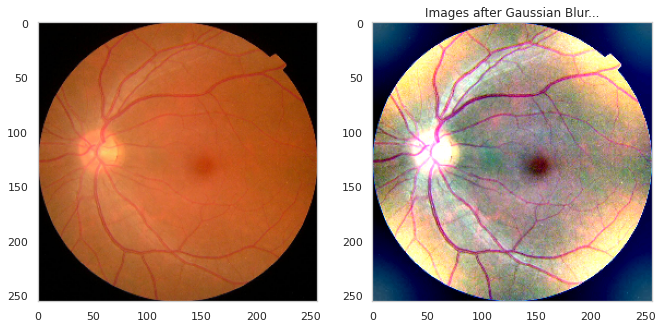

In [11]:
# APPLYING GAUSSIAN BLUR TO THE IMAGES TO REMOVE IRREGULARITIES

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('Images after Gaussian Blur...')
plt.show()

In [12]:
# APPLYING GAUSSIAN BLUR AND CIRCLE CROP TO THE IMAGES TO BRING ALL THE IMAGES TO ONE FORM

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            print(img.shape)
        return img
    
    
def circular_crop(img, sigmaX):       
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w, d = img.shape    
    
    x = int(w/2)
    y = int(h/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((h, w), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1049) (1050, 1049) (1050, 1049)
(1050, 1049, 3)


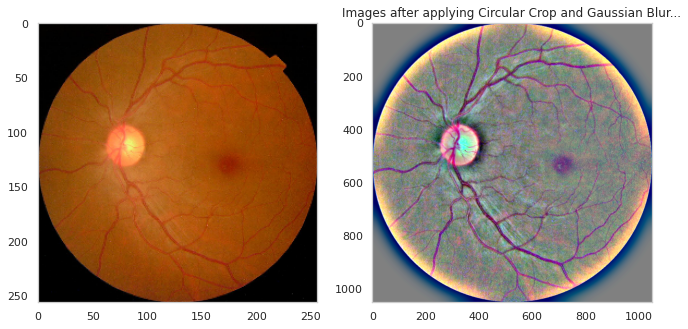

In [13]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circular_crop(img,sigmaX = 30)
f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('Images after applying Circular Crop and Gaussian Blur...')
plt.show()

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1049) (1050, 1049) (1050, 1049)
(1050, 1049, 3)
(1736, 2260) (1736, 2260) (1736, 2260)
(1736, 2260, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(2136, 2712) (2136, 2712) (2136, 2712)
(2136, 2712, 3)
(2136, 2137) (2136, 2137) (2136, 2137)
(2136, 2137, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)
(1736, 2258) (1736, 2258) (1736, 2258)
(1736, 2258, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)


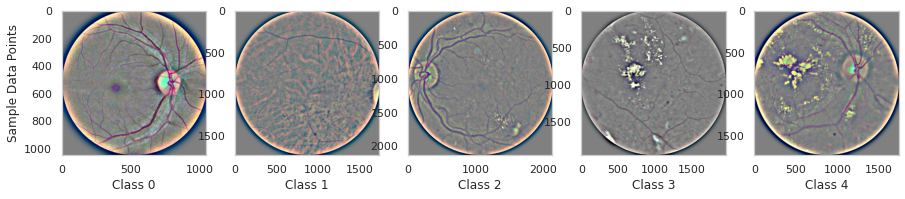

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1736, 2258) (1736, 2258) (1736, 2258)
(1736, 2258, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(2136, 2710) (2136, 2710) (2136, 2710)
(2136, 2710, 3)
(2136, 2137) (2136, 2137) (2136, 2137)
(2136, 2137, 3)
(480, 640) (480, 640) (480, 640)
(480, 640, 3)
(480, 481) (480, 481) (480, 481)
(480, 481, 3)
(2537, 3035) (2537, 3035) (2537, 3035)
(2537, 3035, 3)
(2521, 2537) (2521, 2537) (2521, 2537)
(2521, 2537, 3)


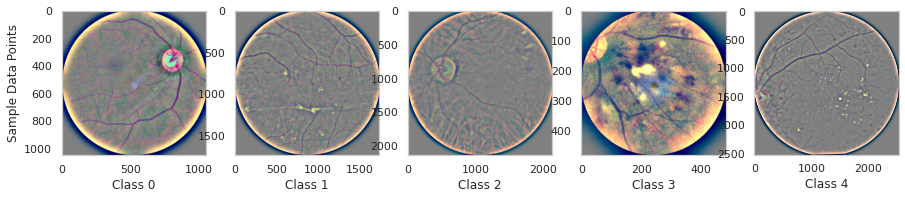

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1049) (1050, 1049) (1050, 1049)
(1050, 1049, 3)
(1736, 2266) (1736, 2266) (1736, 2266)
(1736, 2266, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(2136, 2714) (2136, 2714) (2136, 2714)
(2136, 2714, 3)
(2136, 2137) (2136, 2137) (2136, 2137)
(2136, 2137, 3)
(1000, 1258) (1000, 1258) (1000, 1258)
(1000, 1258, 3)
(997, 1001) (997, 1001) (997, 1001)
(997, 1001, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)


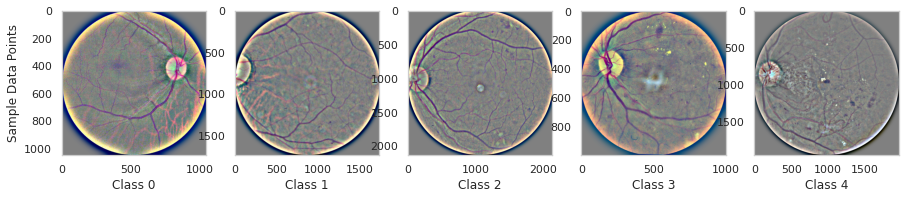

In [14]:
def visualize_imgs(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circular_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

visualize_imgs(df_train,3,sigmaX = 30)

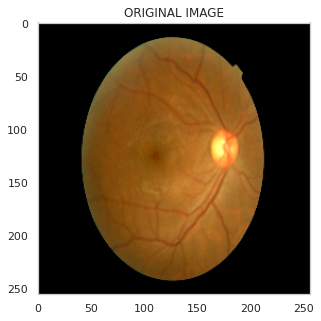

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


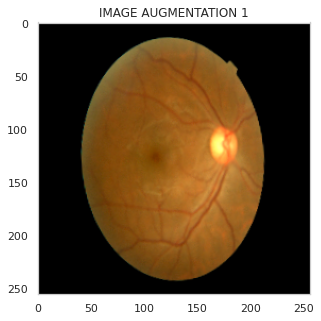

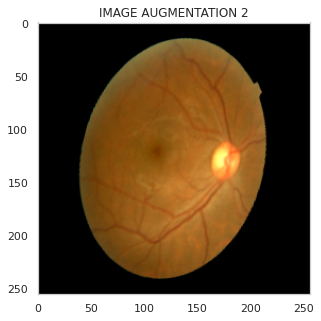

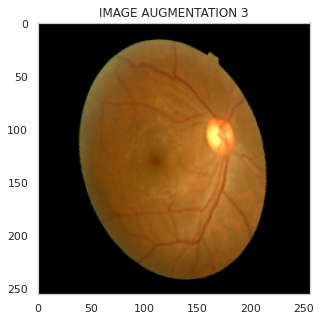

In [15]:
# PERFORMING DATA AUGMENTATION

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

generate_augmentations(3)

In [16]:
# PERFORMING TESTING ON TRAINING SET

df_train_train,df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_valid.shape)

(2929, 4) (733, 4)


In [17]:
# DISPLAYING THE TRAIN DATASET FOR PROCESSING

df_train_train.head(5)

,id_code,diagnosis,file_path,file_name
781,382752f6694a,1,./train_images/382752f6694a.png,382752f6694a.png
361,1a90fad9ffa2,4,./train_images/1a90fad9ffa2.png,1a90fad9ffa2.png
2750,be6cbf6e5b10,0,./train_images/be6cbf6e5b10.png,be6cbf6e5b10.png
338,190a309f2cc5,0,./train_images/190a309f2cc5.png,190a309f2cc5.png
1866,83d6e40c869f,2,./train_images/83d6e40c869f.png,83d6e40c869f.png


In [18]:
# DISPLAYING THE TEST DATASET FOR PROCESSING

df_train_valid.head(5)

,id_code,diagnosis,file_path,file_name
603,2a4520f1f9a3,0,./train_images/2a4520f1f9a3.png,2a4520f1f9a3.png
3172,dc3c0d8ee20b,2,./train_images/dc3c0d8ee20b.png,dc3c0d8ee20b.png
3556,f7735b6d47f7,0,./train_images/f7735b6d47f7.png,f7735b6d47f7.png
3447,ef8109305128,1,./train_images/ef8109305128.png,ef8109305128.png
1440,653534ded339,2,./train_images/653534ded339.png,653534ded339.png


In [19]:
# CONSIDERING VALID_DATA TO BE THE TEST_DATA

df_train_test = df_train_valid
print(df_train_train.shape,df_train_valid.shape)

(2929, 4) (733, 4)


In [20]:
# CREATING FILES TO UPLOAD PROCESSED DATA

file = open('/kaggle/working/df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('/kaggle/working/df_train_test', 'wb')
pickle.dump(df_train_test, file)
file.close()

In [21]:
file = open('/kaggle/working/df_train_train', 'rb')
df_train_train = pickle.load(file)
file.close()

file = open('/kaggle/working/df_train_test', 'rb')
df_train_test = pickle.load(file)
file.close()

In [22]:
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [23]:
# WE USE IMAGES OF SIZE 512 

IMG_SIZE  = 512

In [24]:
# CREATING NEW DIRECTORIES FOR STORING FILES

os.mkdir('/kaggle/working/train_images_resized_preprocessed')
os.mkdir('/kaggle/working/test_images_resized_preprocessed')

In [25]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def generate_augmentations(img, lim=3):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    imgs = []
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        imgs.append(((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8)))
    return imgs 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images/','{}.png'.format(file))
    output_filepath = os.path.join('/kaggle/working/','train_images_resized_preprocessed/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    imgs = generate_augmentations(img)
    for i in range(3):
        cv2.imwrite(output_filepath, cv2.resize(imgs[i], (IMG_SIZE,IMG_SIZE)))
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def preprocess_image1(file):
    input_filepath = os.path.join('./','train_images/','{}.png'.format(file))
    output_filepath = os.path.join('/kaggle/working/','test_images_resized_preprocessed/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    imgs = generate_augmentations(img)
    for i in range(3):
        cv2.imwrite(output_filepath, cv2.resize(imgs[i], (IMG_SIZE,IMG_SIZE)))

In [26]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results
def multiprocess_image_processor1(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image1, imgs)
#     return results

In [27]:
# Use 6 cores
multiprocess_image_processor(4, list(df_train_train.id_code.values))
multiprocess_image_processor1(4, list(df_train_test.id_code.values))

MESSAGE: Running 4 process


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


MESSAGE: Running 4 process


In [66]:
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
IMG_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
WARMUP_EPOCHS = 5


LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = len(df_train_train) // BATCH_SIZE
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE

In [67]:
# CONVERTING MULTIPLE LABELS TO BINARY MATRIX

def multiple_outputs(generator,dataframe, image_dir, batch_size, height,width, subset):
    gen = generator.flow_from_dataframe(
        dataframe = dataframe,
        x_col = "file_name",
        y_col = "diagnosis",
        directory = image_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset)
    
    mlb = MultiLabelBinarizer(classes = range(N_CLASSES))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [68]:
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.,validation_split = 0.0)

train_generator = multiple_outputs(generator = train_datagen,dataframe = df_train_train,
                                   image_dir="/kaggle/working/train_images_resized_preprocessed/",
                                   batch_size=BATCH_SIZE,height = HEIGHT,width = WIDTH,
                                   subset='training')
     
valid_generator = multiple_outputs(generator = train_datagen,dataframe = df_train_test,
                                   image_dir="/kaggle/working/test_images_resized_preprocessed/",
                                   batch_size=BATCH_SIZE,height = HEIGHT,width = WIDTH,
                                   subset='validation')

In [69]:
# APPLYING MUTI-TASK LEARNING USING ResNet50

input_tensor = Input(shape=(HEIGHT, WIDTH, CANAL))
base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
base_model.load_weights('/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')


x1 = GlobalAveragePooling2D()(base_model.output)
x1 = BatchNormalization()(x1)

x2 = GlobalMaxPooling2D()(base_model.output)
x2 = BatchNormalization()(x2)

x = concatenate([x1,x2])

# Regression - 1
xr = Dense(2048, activation='relu')(x)
xr = Dropout(0.5)(xr)
xr = Dense(1,activation = 'linear',name = 'regression_output')(xr)

# Classification - 2
xc = Dense(2048, activation='relu')(x)
xc = Dropout(0.5)(xc)
xc = Dense(N_CLASSES,activation = 'softmax',name = 'classification_output')(xc)

# Ordinal Regression - 3
xo = Dense(2048, activation='relu')(x)
xo = Dropout(0.5)(xo)
xo = Dense(N_CLASSES,activation = 'softmax',name = 'ordinal_regression_output')(xo)

model = Model(inputs = [input_tensor], outputs = [xr,xc,xo])

In [70]:
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [71]:
STEP_SIZE_TRAIN = len(df_train_train)//BATCH_SIZE
STEP_SIZE_VALID = len(df_train_test)//BATCH_SIZE
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

91 22


In [72]:
# We perform cosine learning rate decay as the first few epochs will have a larger error rate and the training done after those will only increase the number of epochs which inevidently increases processing time. In-order to prevent this, we use warm-up factor which increases the learning rate from 0 to a certain value by a factor during a period. The training will begin after the epoch has reached a certain value. 

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

In [73]:
cosine_lr = WarmUpCosineDecayScheduler(learning_rate_base = LEARNING_RATE,
                                       total_steps=TOTAL_STEPS_1st,
                                       warmup_learning_rate=0.0,
                                       warmup_steps=TOTAL_STEPS_1st,
                                       hold_base_rate_steps=(2 * STEP_SIZE))

callback_list = [cosine_lr]

In [74]:
# RUNNING THE MODEL....

model.compile(optimizer = optimizers.SGD(lr=LEARNING_RATE),
              loss={'regression_output': 'mean_absolute_error', 
                    'classification_output': 'categorical_crossentropy',
                    'ordinal_regression_output' : 'binary_crossentropy'
                    },
              metrics = ['accuracy'])

In [75]:
history = model.fit_generator(generator=train_generator,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs=25,
                               callbacks = callback_list,
                               verbose=1).history

Found 2929 validated image filenames belonging to 5 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
91/91 [==============================] - ETA: 0s - loss: 5.4930 - regression_output_loss: 2.0389 - classification_output_loss: 2.4052 - ordinal_regression_output_loss: 1.0490 - regression_output_accuracy: 0.3682 - classification_output_accuracy: 0.1761 - ordinal_regression_output_accuracy: 0.1037Found 0 validated image filenames belonging to 5 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


91/91 [==============================] - 108s 1s/step - loss: 5.4904 - regression_output_loss: 2.0376 - classification_output_loss: 2.4041 - ordinal_regression_output_loss: 1.0487 - regression_output_accuracy: 0.3681 - classification_output_accuracy: 0.1764 - ordinal_regression_output_accuracy: 0.1038 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - val_classification_output_loss: 0.0000e+00 - val_ordinal_regression_output_loss: 0.0000e+00 - val_regression_output_accuracy: 0.0000e+00 - val_classification_output_accuracy: 0.0000e+00 - val_ordinal_regression_output_accuracy: 0.0000e+00
Epoch 2/25
91/91 [==============================] - 99s 1s/step - loss: 4.2845 - regression_output_loss: 1.5200 - classification_output_loss: 1.8144 - ordinal_regression_output_loss: 0.9502 - regression_output_accuracy: 0.3410 - classification_output_accuracy: 0.3347 - ordinal_regression_output_accuracy: 0.1620 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - val_classific

In [76]:
model.save("/kaggle/working/model_pre_training.h5")
f = open("/kaggle/working/history_pre_training","wb")
pickle.dump(history,f)
f.close()

In [39]:
# THE BASE LAYER IS FREEZED

for layer in model.layers:
    layer.trainable = False

for i in range(-14,0):
  model.layers[i].trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [40]:
# APPLYING LOSS FUNCTIONS

def binary_focal_loss(gamma=2., alpha=.25):
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [41]:
# APPLYING CATEGORICAL FOCAL LOSS - SOFTMAX - We apply this to see the probability of the results to reduce class imbalance

def categorical_focal_loss(gamma=2., alpha=.25):
    def categorical_focal_loss_fixed(y_true, y_pred):

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

In [42]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=5,
                              callbacks = callback_list,
                              verbose=1).history
model.save("/kaggle/working/model_main_training1.h5")
f = open("/kaggle/working/history_main_training","wb")
pickle.dump(history,f)
f.close()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
91/91 [==============================] - 99s 1s/step - loss: 2.2716 - regression_output_loss: 2.0716 - classification_output_loss: 0.0384 - ordinal_regression_output_loss: 0.1616 - regression_output_accuracy: 0.3723 - classification_output_accuracy: 0.6511 - ordinal_regression_output_accuracy: 0.7931 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - val_classification_output_loss: 0.0000e+00 - val_ordinal_regression_output_loss: 0.0000e+00 - val_regression_output_accuracy: 0.0000e+00 - val_classification_output_accuracy: 0.0000e+00 - val_ordinal_regression_output_accuracy: 0.0000e+00
Epoch 2/5
91/91 [==============================] - 89s 990ms/step - loss: 2.4699 - regression_output_loss: 2.2577 - classification_output_loss: 0.0411 - ordinal_regression_output_loss: 0.1711 - regression_output_accuracy: 0.3676 - classification_output_accuracy: 0.6618 - ordinal_regression_output_accuracy: 0.7793 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - va

In [43]:
# UNFREEZING LAYERS TO INCLUDE THEM IN TRAINING

for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [44]:
model.compile(optimizer = optimizers.Adam(lr=LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=25,
                              callbacks = callback_list,
                              verbose=1).history

model.save("/kaggle/working/model_main_training.h5")
f = open("/kaggle/working/history_main_training","wb")
pickle.dump(history,f)
f.close()

Epoch 1/25
91/91 [==============================] - 109s 1s/step - loss: 2.3162 - regression_output_loss: 2.1168 - classification_output_loss: 0.0407 - ordinal_regression_output_loss: 0.1587 - regression_output_accuracy: 0.4055 - classification_output_accuracy: 0.6285 - ordinal_regression_output_accuracy: 0.8029 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - val_classification_output_loss: 0.0000e+00 - val_ordinal_regression_output_loss: 0.0000e+00 - val_regression_output_accuracy: 0.0000e+00 - val_classification_output_accuracy: 0.0000e+00 - val_ordinal_regression_output_accuracy: 0.0000e+00
Epoch 2/25
91/91 [==============================] - 99s 1s/step - loss: 2.2156 - regression_output_loss: 2.0183 - classification_output_loss: 0.0383 - ordinal_regression_output_loss: 0.1590 - regression_output_accuracy: 0.3739 - classification_output_accuracy: 0.6464 - ordinal_regression_output_accuracy: 0.7751 - val_loss: 0.0000e+00 - val_regression_output_loss: 0.0000e+00 - va